A walk through of [`DGL` library](https://docs.dgl.ai/index.html). Deep Graph library (DGL) is a Python package built for easy implementation of graph neural network model family on top of existing deep learning framework (e.g., Pytorch, MXNet etc.). More detials can be found on the official website.

## 1. Create a Graph
No surprise, the data used for graph neural netowrk is graph. Let's see how to create a graph in `DGL`.

### Method 1: Create a graph from `networkx` and convert it into a `DGLGraph`

note: `DGLGraph` is always directional

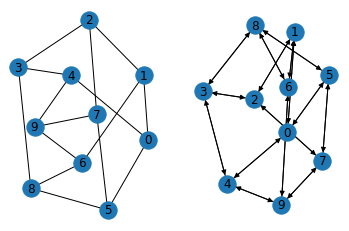

In [1]:
import networkx as nx
import dgl

g_nx = nx.petersen_graph()
g_dgl = dgl.DGLGraph(g_nx)

import matplotlib.pyplot as plt
plt.subplot(121)
nx.draw(g_nx, with_labels=True)
plt.subplot(122)
nx.draw(g_dgl.to_networkx(), with_labels=True)

plt.show()

### Method 2: Create a graph by calling DGL interface

 - use `add_nodes` to add nodes
 - use `add_edge` to add directional links. src and dst can be two lists/torch tensor.

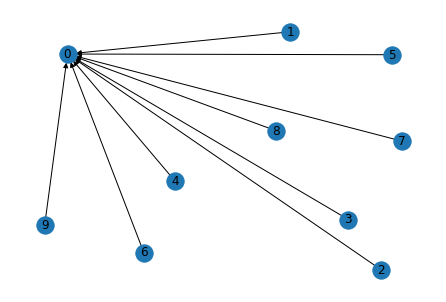

In [2]:
import dgl
import torch

g = dgl.DGLGraph()
g.add_nodes(10)
# A couple edges one-by-one
for i in range(1, 5):
    g.add_edge(i, 0)
# A few more with a paired list
src = list(range(5, 8)); dst = [0]*3
g.add_edges(src, dst)
# finish with a pair of tensors
src = torch.tensor([8, 9]); dst = torch.tensor([0, 0])
g.add_edges(src, dst)

import networkx as nx
import matplotlib.pyplot as plt
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

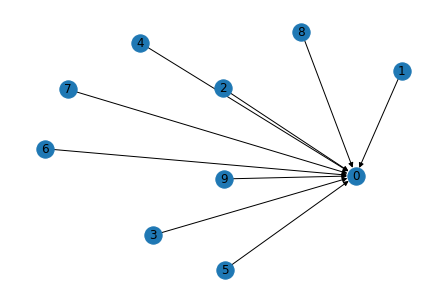

In [3]:
# Edge broadcasting will do star graph in one go!
g.clear(); g.add_nodes(10)
src = torch.tensor(list(range(1, 10)));
g.add_edges(src, 0)

import networkx as nx
import matplotlib.pyplot as plt
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

In [4]:
g

DGLGraph(num_nodes=10, num_edges=9,
         ndata_schemes={}
         edata_schemes={})

A `DGLGraph` contains four major elements: the node, the edges, and the feature of nodes and edges.

In [5]:
g.nodes()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
g.edges()

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]))

The edges are stored as two link lists (one list of start nodes and one list of end nodes).

#### Assige features to nodes or edges 

- The features are represented as dictionary of names (strings) and tensors, called `fields`.

In [7]:
feature_x = torch.randn(10,3)
g.ndata['x'] = feature_x

`ndata` is a snytax sugar to access the state of all nodes. Srates are stored in a container `data` that hosts a user-defined dictionary.

In [8]:
g.ndata['x']

tensor([[-1.3337,  1.0653, -0.4484],
        [-0.6797,  0.1350, -0.3534],
        [ 0.6005, -0.7793, -0.2142],
        [ 0.4719,  0.5237, -0.8962],
        [-0.3206, -1.7652, -1.4549],
        [-1.4293, -0.3933,  1.1998],
        [ 0.9589,  0.9919, -1.2667],
        [ 0.7001,  1.5545,  0.7258],
        [-0.9071, -0.2060, -0.0214],
        [-0.5417,  0.3960,  2.3605]])

We can also access the feature_x of individual node.

In [9]:
g.nodes[0].data['x']

tensor([[-1.3337,  1.0653, -0.4484]])

In [10]:
g.nodes[:].data['x'] # note currently only full slice `:` is supported, e.g., [:3] will generate an error

tensor([[-1.3337,  1.0653, -0.4484],
        [-0.6797,  0.1350, -0.3534],
        [ 0.6005, -0.7793, -0.2142],
        [ 0.4719,  0.5237, -0.8962],
        [-0.3206, -1.7652, -1.4549],
        [-1.4293, -0.3933,  1.1998],
        [ 0.9589,  0.9919, -1.2667],
        [ 0.7001,  1.5545,  0.7258],
        [-0.9071, -0.2060, -0.0214],
        [-0.5417,  0.3960,  2.3605]])

When we call the `DGLGraph`, we can now see the node data.

In [11]:
g

DGLGraph(num_nodes=10, num_edges=9,
         ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)}
         edata_schemes={})

#### Assign edge feature is similar to that of node features. There are two ways to access features to the edges:

 - Access edge set with IDs
 - Access edge with the endpoints

In [12]:
feature_y = torch.randn(9,2)

g.edata['y'] =  feature_y

In [13]:
g

DGLGraph(num_nodes=10, num_edges=9,
         ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)}
         edata_schemes={'y': Scheme(shape=(2,), dtype=torch.float32)})

Feature_y for all the edges.

In [14]:
g.edges[:].data['y']

tensor([[-0.1188,  0.6555],
        [-2.5768, -0.3540],
        [-0.8158, -1.1368],
        [-0.2116, -0.8032],
        [-0.8119,  0.6109],
        [ 0.9817,  0.3814],
        [ 0.6001, -0.8499],
        [ 1.0243, -2.0709],
        [-1.5139, -0.3658]])

Check the feature_y of the first edge by ID.

In [15]:
g.edges[0].data['y']

tensor([[-0.1188,  0.6555]])

Feature_y of edge: 1 -> 0

In [16]:
g.edges[1, 0].data['y']

tensor([[-0.1188,  0.6555]])

Feature_y of edges: 1 -> 0; 2 -> 0; 3 -> 0;

In [17]:
g.edges[[1, 2, 3], [0, 0, 0]].data['y']

tensor([[-0.1188,  0.6555],
        [-2.5768, -0.3540],
        [-0.8158, -1.1368]])

#### After assignments,  each node or edge field will be associated with a scheme containing the shape and data type of it field value.

In [18]:
g.node_attr_schemes()

{'x': Scheme(shape=(3,), dtype=torch.float32)}

In [19]:
g.edge_attr_schemes()

{'y': Scheme(shape=(2,), dtype=torch.float32)}

#### You can also remove node or edge states from the graph

In [20]:
g.ndata.pop('x')
g

DGLGraph(num_nodes=10, num_edges=9,
         ndata_schemes={}
         edata_schemes={'y': Scheme(shape=(2,), dtype=torch.float32)})

### 2. Chemical Graph
Molecules are naturally graph. Deep learning on molecular graph has been applied on various tasks. Let convert molecules to molecular graph with `DGL` so that we can use them for graph neural network. In a molecular graph, the atoms are represented as nodes and the chemical bonds are represented by the edges. There are also features associated with the nodes and edges (e.g., atom type).

A useful resource: [DGL for Chemistry](https://github.com/dmlc/dgl/tree/master/examples/pytorch/model_zoo/chem) [[source code]](https://github.com/dmlc/dgl/tree/master/python/dgl/data/chem).

The process of coverting molecules to representations that suitable for machine learning is called featurization. The featurization in `DGL` includes two steps:
 - Convert molecules into graph
 - Initizlize node/edge features, e.g., atom typing and bond typing. 
 
`SMILES` is a linear representation of molecules which encodes a molecular graph in a string with some specific syntax. `RDKit` is a python package can handle chemical data. E.g., convert SMILES to RDKit molecules.

In [39]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from dgl.data.chem import mol_to_bigraph, smiles_to_bigraph, mol_to_complete_graph, smiles_to_complete_graph
from dgl.data.chem import CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgl.data.chem import BaseAtomFeaturizer, atom_mass, atom_degree_one_hot
from dgl.data.chem import BaseBondFeaturizer, bond_type_one_hot, bond_is_in_ring
from dgl.data.chem import Tox21

Let's first see what a featurized dataset looks like. Here is an example of Tox21 dataset. The Tox21 data is pre-built in the `DGL` library. 

In [25]:
dataset = Tox21(smiles_to_bigraph, CanonicalAtomFeaturizer())

Loading previously saved dgl graphs...


In [41]:
dataset[0]

('CCOc1ccc2nc(S(N)(=O)=O)sc2c1', DGLGraph(num_nodes=16, num_edges=34,
          ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
          edata_schemes={}), tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), tensor([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.]))

Data are stored in a 4-value tuple (SMILES, DGLGraph, label, mask). let's check the 2nd sample (molecule) in the data. The molecular graph only contains atom features.

In [26]:
smiles, g, label, mask = dataset[1]
g

DGLGraph(num_nodes=15, num_edges=32,
         ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
         edata_schemes={})

In [27]:
print(g.ndata['h'].shape)
g.ndata['h']

torch.Size([15, 74])


tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

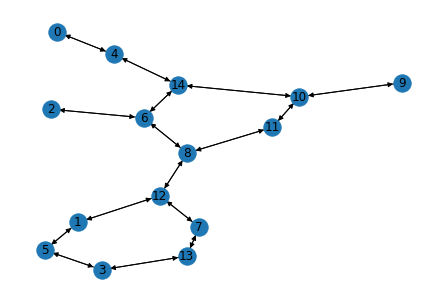

In [28]:
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

### Convert a SMILES to `DGLGraph` with features

In [22]:
smiles = 'CNC(=O)Oc1cc(C(C)(C)C)cc(C(C)(C)C)c1'

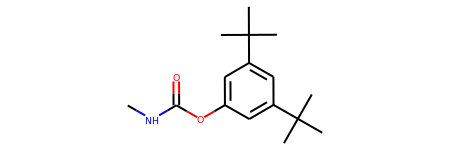

In [23]:
mol = Chem.MolFromSmiles(smiles)
mol

For converting SMILES/RDKit molecules to `DGLGraph`, there are four functions:

 - mol_to_bigraph
 - smiles_to_bigraph
 - mol_to_complete_graph
 - smiles_to_complete_graph

In [29]:
smiles = 'CNC(=O)Oc1cc(C(C)(C)C)cc(C(C)(C)C)c1'
mol = Chem.MolFromSmiles(smiles)

In [30]:
bigraph_smiles = smiles_to_bigraph(smiles)
bigraph_smiles

DGLGraph(num_nodes=19, num_edges=38,
         ndata_schemes={}
         edata_schemes={})

The graph above is without any node/edge features. Let's initialize some node features with `BaseAtomFeaturizer` function and bond features with `BaseBondFeaturizer`. These functions take a dictionary of featurizing functions.

In [31]:
atom_featurizer = BaseAtomFeaturizer({'mass': atom_mass, 'degree': atom_degree_one_hot})

In [32]:
atom_features = atom_featurizer(mol)
atom_features

{'mass': tensor([[0.1201],
         [0.1401],
         [0.1201],
         [0.1600],
         [0.1600],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201],
         [0.1201]]),
 'degree': tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 

In [33]:
bond_featurizer = BaseBondFeaturizer({'bond_type': bond_type_one_hot, 'inRing': bond_is_in_ring})
bond_features = bond_featurizer(mol)
bond_features

{'bond_type': tensor([[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0

Now, we can add the atom and bond features to the molecular graph.

In [34]:
bigraph_smiles.ndata['mass'] = atom_features['mass']
bigraph_smiles.ndata['degree'] = atom_features['degree']

bigraph_smiles.edata['bond_type'] = bond_features['bond_type']
bigraph_smiles.edata['inRing'] = bond_features['inRing']

In [35]:
bigraph_smiles

DGLGraph(num_nodes=19, num_edges=38,
         ndata_schemes={'mass': Scheme(shape=(1,), dtype=torch.float32), 'degree': Scheme(shape=(11,), dtype=torch.float32)}
         edata_schemes={'bond_type': Scheme(shape=(4,), dtype=torch.float32), 'inRing': Scheme(shape=(1,), dtype=torch.float32)})

### Default Atom/Bond featurizers in DGL for Chemistry

`DGL` has a default featurizer for atoms and edges.

The **atom features** include:
    
**One hot encoding of the atom type**. The supported atom types include
      ``C``, ``N``, ``O``, ``S``, ``F``, ``Si``, ``P``, ``Cl``, ``Br``, ``Mg``,
      ``Na``, ``Ca``, ``Fe``, ``As``, ``Al``, ``I``, ``B``, ``V``, ``K``, ``Tl``,
      ``Yb``, ``Sb``, ``Sn``, ``Ag``, ``Pd``, ``Co``, ``Se``, ``Ti``, ``Zn``,
      ``H``, ``Li``, ``Ge``, ``Cu``, ``Au``, ``Ni``, ``Cd``, ``In``, ``Mn``, ``Zr``,
      ``Cr``, ``Pt``, ``Hg``, ``Pb``.
    **One hot encoding of the atom degree**. The supported possibilities
      include ``0 - 10``.
    **One hot encoding of the number of implicit Hs on the atom**. The supported
      possibilities include ``0 - 6``.
    **Formal charge of the atom**.
    **Number of radical electrons of the atom**.
    **One hot encoding of the atom hybridization**. The supported possibilities include
      ``SP``, ``SP2``, ``SP3``, ``SP3D``, ``SP3D2``.
    **Whether the atom is aromatic**.
    **One hot encoding of the number of total Hs on the atom**. The supported possibilities
      include ``0 - 4``.
      
The **bond features** include:

**One hot encoding of the bond type**. The supported bond types include
      ``SINGLE``, ``DOUBLE``, ``TRIPLE``, ``AROMATIC``.
    **Whether the bond is conjugated.**.
    **Whether the bond is in a ring of any size.**
    **One hot encoding of the stereo configuration of a bond**. The supported bond stereo
      configurations include ``STEREONONE``, ``STEREOANY``, ``STEREOZ``, ``STEREOE``,
      ``STEREOCIS``, ``STEREOTRANS``.

In [36]:
atom_featurizer = CanonicalAtomFeaturizer()
bond_featurizer = CanonicalBondFeaturizer()

In [37]:
atom_featurizer(mol)

{'h': tensor([[1., 0., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]])}

In [38]:
bond_featurizer(mol)

{'e': tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0